In [1]:
import os
os.chdir('../..')

In [33]:
import numpy as np
import pandas as pd

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 
from collections import Iterable
from sklearn.linear_model import LinearRegression

import scipy.stats as st

import matplotlib.pyplot as plt
import matplotlib

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Load the files

In [3]:
files = ['../data/Chicago/full.csv', 
         '../synth_data/Chicago/tgan_100.csv', 
         '../synth_data/Chicago/tgan_1000.csv', 
         '../synth_data/Chicago/ctgan.csv',
         '../synth_data/Chicago/ctgan_300.csv',
         '../synth_data/Chicago/ctgan_1000.csv']
labels = ['original', 'tgan - 100ep', 'tgan - 1000ep', 'ctgan - 100ep', 'ctgan - 300ep', 'ctgan - 1000ep']

In [4]:
dfs = [pd.read_csv(file) for file in files]

# All to numeric

In [5]:
ints = ['travel_dow', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'education_level', 'age']
floats = ['departure_time', 'distance', 'license']

In [6]:
dct = {}

for i in ints:
    dct[i] = 'int64'
    
for i in floats:
    dct[i] = 'float64'

In [7]:
dct

{'travel_dow': 'int64',
 'hh_vehicles': 'int64',
 'hh_size': 'int64',
 'hh_bikes': 'int64',
 'hh_descr': 'int64',
 'hh_income': 'int64',
 'gender': 'int64',
 'education_level': 'int64',
 'age': 'int64',
 'departure_time': 'float64',
 'distance': 'float64',
 'license': 'float64'}

In [8]:
dfs = [df.astype(dct) for df in dfs]

In [9]:
choices = {}
trip_purpose = {}
work_status = {}

for c in ['choice', 'trip_purpose', 'work_status']: 
    dct = {}
    
    for n, i in enumerate(dfs[0][c].unique()):
        if c == 'choice':
            choices[n] = i
            
        if c == 'trip_purpose':
            trip_purpose[n] = i
            
        if c == 'work_status':
            work_status[n] = i
        
        dct[i] = n
        
    dfs = [df.replace(dct) for df in dfs]

In [10]:
dfs[0].dtypes

choice               int64
travel_dow           int64
trip_purpose         int64
distance           float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status          int64
departure_time     float64
dtype: object

# Standardize the data

In [11]:
full_df = dfs[0]
for i in range(1, len(dfs)):
    
    full_df = full_df.append(dfs[i], ignore_index=True)

scaler = StandardScaler()
scaler.fit(full_df)

StandardScaler()

In [12]:
stand = []

for df in dfs:
    stand.append(scaler.transform(df))

# Fit PCA and transform the data

In [43]:
pca = decomposition.PCA(n_components=len(dfs[0].columns))
pca.fit(stand[0])

PCA(n_components=15)

In [19]:
cols = []

for i in range(len(dfs[0].columns)):
    cols.append('pa' + str(i+1))

In [21]:
pca_dfs = []

for df in dfs:
    pca_dfs.append(pd.DataFrame(pca.transform(df), columns=cols))

In [24]:
def get_frequency_list(original, synthetic, max_num_bins):
    """
    Compute the frequency lists
    """
    
    # Check if the number of unique values is less than the max
    # number of bins for the cat variables
    unique_vals = set(np.unique(original)).union(set(np.unique(synthetic)))        
    
    if len(unique_vals) > max_num_bins:
        cat = False
    else:
        cat = True
    
    eps = 1e-10
    # Compute min and max values between both datasets
    min_val = min(np.min(original), np.min(synthetic)) - eps
    max_val = max(np.max(original), np.max(synthetic)) + eps
    
    # Compute the bins
    bins = []
    if cat:
        # bins = all values
        bins = list(unique_vals)
        bins.sort()
    else:
        # bins = hist bins
        delta = (max_val-min_val)/max_num_bins
        for i in range(max_num_bins+1):
            bins.append(min_val+delta*i)
            
    # Calculate the frequencies
    freqs = []
    if cat:
        count_orig = [(original==b).sum() for b in bins]
        count_synth = [(synthetic==b).sum() for b in bins]
        
        freqs = [count_orig, count_synth]
    else:
        hist_orig, _ = np.histogram(original, bins)
        hist_synth, _ = np.histogram(synthetic, bins)
        
        freqs = [hist_orig, hist_synth]

            
    return freqs, bins

In [25]:
def stats(freq_list_orig, freq_list_synth):
    """
    Different statistics computed on the frequency list
    
    """
    freq_list_orig, freq_list_synth = np.array(freq_list_orig), np.array(freq_list_synth)
    corr_mat = np.corrcoef(freq_list_orig, freq_list_synth)
    corr = corr_mat[0, 1]
    if np.isnan(corr): corr = 0.0
    # MAE
    mae = np.absolute(freq_list_orig - freq_list_synth).mean()
    # RMSE
    rmse = np.linalg.norm(freq_list_orig - freq_list_synth) / np.sqrt(len(freq_list_orig))
    # SRMSE
    freq_list_orig_avg = freq_list_orig.mean()
    srmse = rmse / freq_list_orig_avg
    # r-square
    u = np.sum((freq_list_synth - freq_list_orig)**2)
    v = np.sum((freq_list_orig - freq_list_orig_avg)**2)
    r2 = 1.0 - u / v
    stat = {'mae': mae, 'rmse': rmse, 'r2': r2, 'srmse': srmse, 'corr': corr}
    
    return stat

In [26]:
def plot(freqs_original, freqs_synthetic, title=None):
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)
    
    min_val = min(np.min(freqs_original), np.min(freqs_synthetic))
    max_val = max(np.max(freqs_original), np.max(freqs_synthetic))
    
    plt.plot(freqs_original, freqs_synthetic, 'ok')
    
    reg = LinearRegression()
    reg.fit(np.array(freqs_original)[:, np.newaxis], np.array(freqs_synthetic))
    
    xfit = np.linspace(np.min(freqs_original), np.max(freqs_original), 10)
    yfit = reg.predict(xfit[:, np.newaxis])
    
    plt.plot(xfit, yfit, 'grey')
    
    stat = stats(freqs_original, freqs_synthetic)
    
    str_ = "SRMSE={:.3f}\nR²={:.3f}\ny={:.3f}x".format(stat['srmse'], stat['r2'], reg.coef_[0])
    
    t = plt.text(0.05, 0.9,str_,
                 horizontalalignment='left',
                 verticalalignment='center',
                 transform = ax.transAxes,
                 fontsize=14)
    
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
    
    plt.xlabel('Observed frequencies')
    plt.ylabel('Simulated frequencies')
    
    if title is not None:
        plt.title(title)

In [27]:
orig_freqs = []
synth_freqs = []

for i in range(len(pca_dfs)-1):
    synth_freqs.append([])

for c in pca_dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(pca_dfs[0][c], pca_dfs[i][c], 50)
        
        if i == 1:
            orig_freqs.append(a)
        
        synth_freqs[i-1].append(b)

In [28]:
def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

In [31]:
orig_freqs = list(flatten(orig_freqs))


for i in range(len(synth_freqs)):
    synth_freqs[i] = list(flatten(synth_freqs[i]))

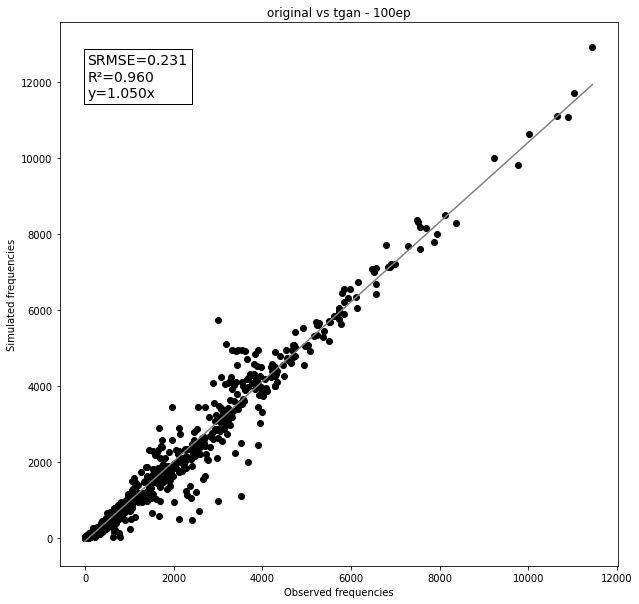

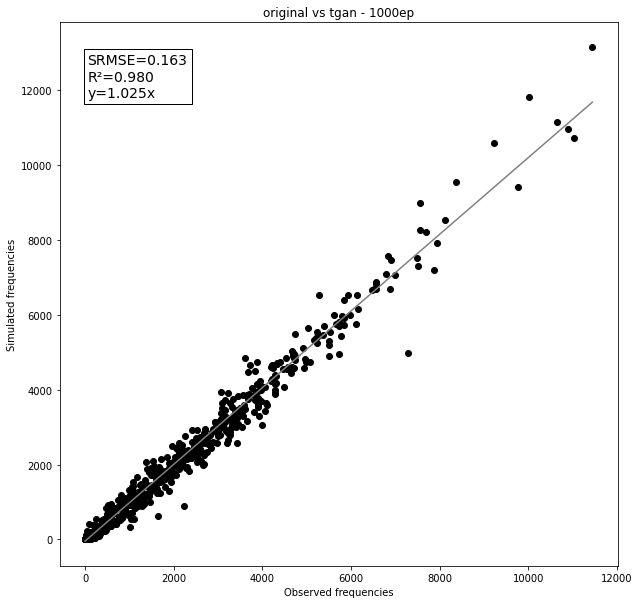

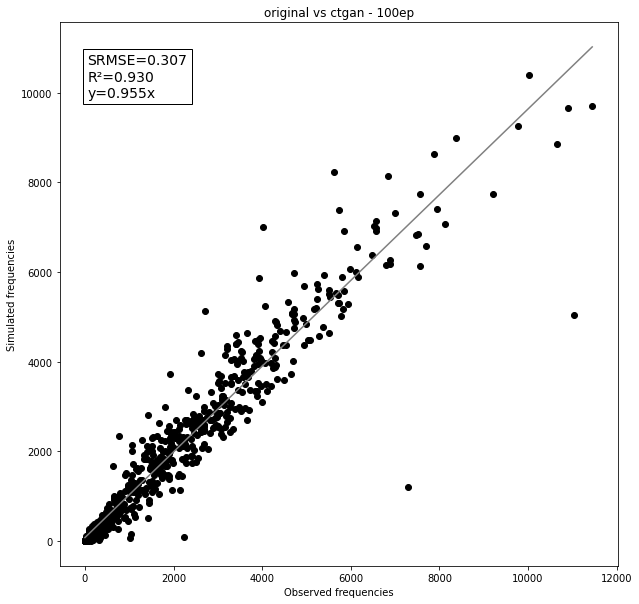

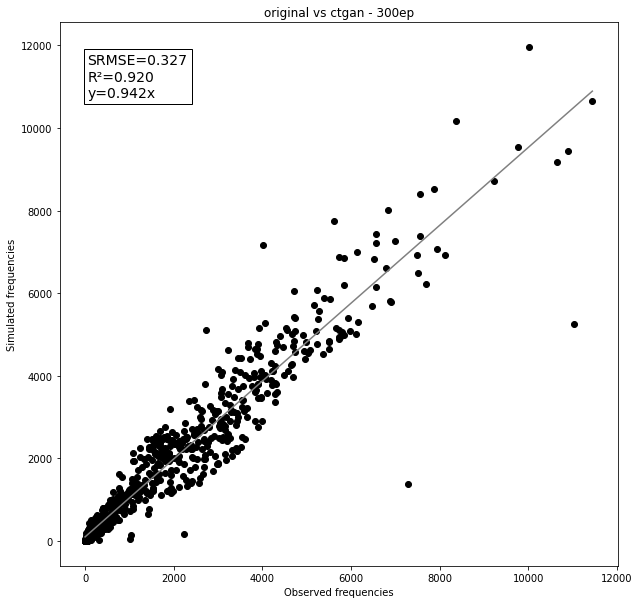

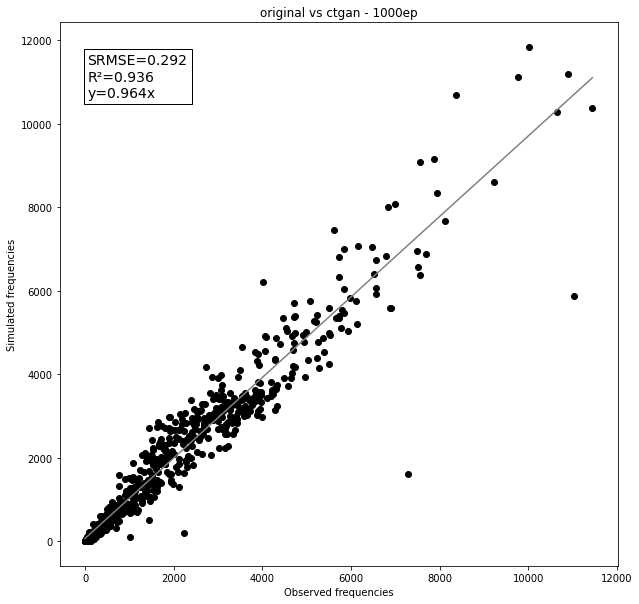

In [34]:
for i in range(len(synth_freqs)):
    plot(orig_freqs, synth_freqs[i], labels[0] + ' vs ' + labels[i+1])

In [35]:
SRMSES = []

for i in range(len(pca_dfs)-1):
    SRMSES.append([])

for c in pca_dfs[0].columns:
    for i in range(1, len(pca_dfs)):
        
        [a,b],bins = get_frequency_list(pca_dfs[0][c], pca_dfs[i][c], 50)
        
        stat = stats(a,b)
        
        SRMSES[i-1].append(stat['srmse'])

Text(0, 0.5, 'SRMSEs')

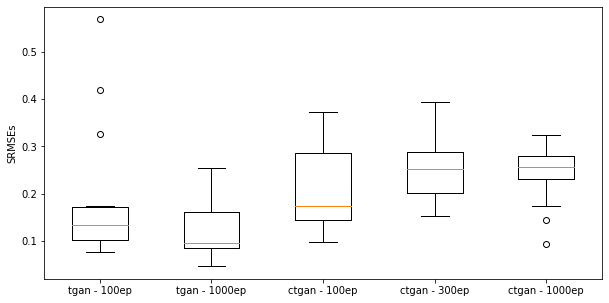

In [37]:
plt.figure(figsize=(10,5))
plt.boxplot(SRMSES)
plt.xticks(range(1,len(SRMSES)+1), labels[1:])
plt.ylabel('SRMSEs')

In [50]:
stats_vals = []

for i in range(len(pca_dfs)-1):
    stats_vals.append({'mae': [], 'rmse': [], 'r2': [], 'srmse': [], 'corr': []})

for c in pca_dfs[0].columns:
    for i in range(1, len(pca_dfs)):
        
        [a,b],bins = get_frequency_list(pca_dfs[0][c], pca_dfs[i][c], 50)
        
        stat = stats(a,b)
        
        for k in stat.keys():
            stats_vals[i-1][k].append(stat[k])

In [54]:
print("Weighted average of SRMSE")
for i in range(len(SRMSES)):
    print("{}: {:.3f}".format(labels[i+1], np.dot(stats_vals[i]['srmse'], pca.explained_variance_ratio_)))

Weighted average of SRMSE
tgan - 100ep: 0.177
tgan - 1000ep: 0.136
ctgan - 100ep: 0.220
ctgan - 300ep: 0.256
ctgan - 1000ep: 0.249


In [55]:
print("Weighted average of R^2")
for i in range(len(SRMSES)):
    print("{}: {:.3f}".format(labels[i+1], np.dot(stats_vals[i]['r2'], pca.explained_variance_ratio_)))

Weighted average of R^2
tgan - 100ep: 0.926
tgan - 1000ep: 0.980
ctgan - 100ep: 0.940
ctgan - 300ep: 0.911
ctgan - 1000ep: 0.930


In [56]:
print("Weighted average of corr")
for i in range(len(SRMSES)):
    print("{}: {:.3f}".format(labels[i+1], np.dot(stats_vals[i]['corr'], pca.explained_variance_ratio_)))

Weighted average of corr
tgan - 100ep: 0.975
tgan - 1000ep: 0.991
ctgan - 100ep: 0.972
ctgan - 300ep: 0.954
ctgan - 1000ep: 0.964
